In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style('whitegrid')

In [2]:
#prices

fuels = pd.read_csv('fuels.csv')
cap = pd.read_csv('cap.csv')

In [3]:
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [4]:
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [5]:
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

In [195]:
locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))
    
    oidx = gen[loc].index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
    gen[loc] = gen[loc].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1)
               )

oidx = gen['NYCA'].index
nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
gen['NYCA'] = gen['NYCA'].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

In [196]:
gen['NYCA'].head()

,Gas (NYCA),Coal (NYCA),Oil (NYCA),Renewables (NYCA),Others (NYCA),Sum (NYCA)
2004-01-01,17199.611475,4248.963934,8223.796721,6387.326230,5611.2,36059.698361
2004-02-01,17371.979235,4251.539071,8222.536885,6398.371585,5611.2,36244.426776
2004-03-01,17556.234426,4254.291803,8221.190164,6410.178689,5611.2,36441.895082
2004-04-01,17734.545902,4256.955738,8219.886885,6421.604918,5611.2,36632.993443
2004-05-01,17918.801093,4259.708470,8218.540164,6433.412022,5611.2,36830.461749


In [197]:
# calculate sum of generating capacity excluding natural gas power plants
locs = ['GJ', 'LI', 'NYC', 'NYCA']
for loc in locs:
    gen[loc]['Sum_woGas (' + str(loc) + ')'] = gen[loc]['Sum (' + str(loc) + ')']-gen[loc]['Gas (' + str(loc) + ')']

In [198]:
ucap = pd.read_csv("../data/Monthly_UCAP_Requirements.csv")
ucap = (ucap
        .set_index(pd.to_datetime(ucap['Date']))
        .drop('Date', axis = 1)
        )

In [199]:
above = pd.read_csv('../data/Monthly_Percent_Cleared_Above.csv')
above = (above
        .set_index(pd.to_datetime(above['Date']))
        .drop('Date', axis = 1)
        )

In [200]:
# shift generating capacity by two years (approximate construction time of a power plant)
#locs = ['GJ', 'LI', 'NYC', 'NYCA']
#gen_shifted = {}
#for loc in locs:
#    gen_shifted[loc] = gen[loc].shift(periods=3, freq="y").shift(periods=1, freq="d")

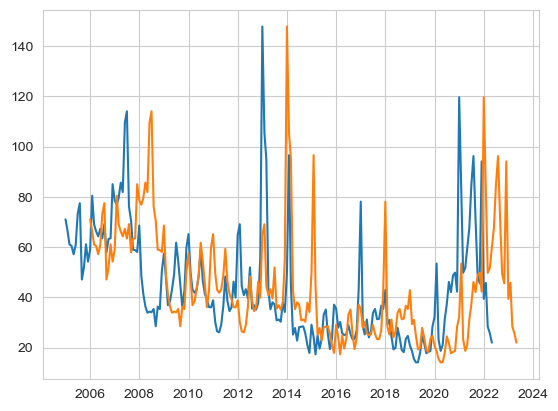

In [201]:
# shift icap/dam prices by one year

nyca_icap_1 = pd.DataFrame()
nyca_icap_1['ICAP-1'] = cap['nyca_icap'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

nyca_dam_1 = pd.DataFrame()
nyca_dam_1['DAM-1'] = dam['nyca_dam'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

plt.plot(nyca_dam_1['DAM-1'])
plt.plot(dam['nyca_dam'])

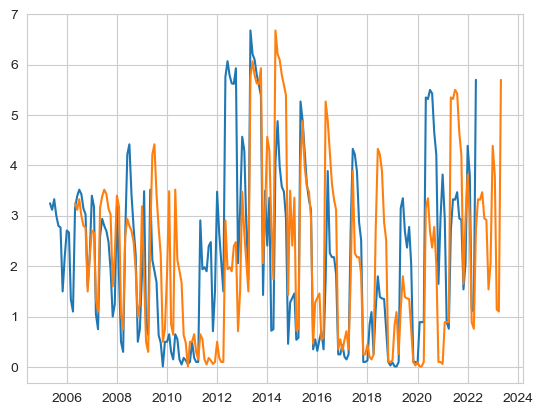

In [202]:
plt.plot(nyca_icap_1['ICAP-1'])
plt.plot(cap['nyca_icap'])

In [203]:
nyc_icap_1 = pd.DataFrame()
nyc_icap_1['ICAP-1'] = cap['nyc_icap'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

nyc_dam_1 = pd.DataFrame()
nyc_dam_1['DAM-1'] = dam['nyc_dam'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

gj_icap_1 = pd.DataFrame()
gj_icap_1['ICAP-1'] = cap['gj_icap'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

gj_dam_1 = pd.DataFrame()
gj_dam_1['DAM-1'] = dam['gj_dam'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

li_icap_1 = pd.DataFrame()
li_icap_1['ICAP-1'] = cap['li_icap'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

li_dam_1 = pd.DataFrame()
li_dam_1['DAM-1'] = dam['li_dam'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

In [204]:
nyca_icap_2 = pd.DataFrame()
nyca_icap_2['ICAP-2'] = cap['nyca_icap'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

nyca_dam_2 = pd.DataFrame()
nyca_dam_2['DAM-2'] = dam['nyca_dam'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

nyc_icap_2 = pd.DataFrame()
nyc_icap_2['ICAP-2'] = cap['nyc_icap'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

nyc_dam_2 = pd.DataFrame()
nyc_dam_2['DAM-2'] = dam['nyc_dam'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

gj_icap_2 = pd.DataFrame()
gj_icap_2['ICAP-2'] = cap['gj_icap'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

gj_dam_2 = pd.DataFrame()
gj_dam_2['DAM-2'] = dam['gj_dam'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

li_icap_2 = pd.DataFrame()
li_icap_2['ICAP-2'] = cap['li_icap'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

li_dam_2 = pd.DataFrame()
li_dam_2['DAM-2'] = dam['li_dam'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

In [205]:
nyca_icap_3 = pd.DataFrame()
nyca_icap_3['ICAP-3'] = cap['nyca_icap'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

nyca_dam_3 = pd.DataFrame()
nyca_dam_3['DAM-3'] = dam['nyca_dam'].shift(periods=-37, freq="m").shift(periods=1, freq="d")


nyc_icap_3 = pd.DataFrame()
nyc_icap_3['ICAP-3'] = cap['nyc_icap'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

nyc_dam_3 = pd.DataFrame()
nyc_dam_3['DAM-3'] = dam['nyc_dam'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

gj_icap_3 = pd.DataFrame()
gj_icap_3['ICAP-3'] = cap['gj_icap'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

gj_dam_3 = pd.DataFrame()
gj_dam_3['DAM-3'] = dam['gj_dam'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

li_icap_3 = pd.DataFrame()
li_icap_3['ICAP-3'] = cap['li_icap'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

li_dam_3 = pd.DataFrame()
li_dam_3['DAM-3'] = dam['li_dam'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

In [206]:
nyca_icap_4 = pd.DataFrame()
nyca_icap_4['ICAP-4'] = cap['nyca_icap'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

nyca_dam_4 = pd.DataFrame()
nyca_dam_4['DAM-4'] = dam['nyca_dam'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

nyc_icap_4 = pd.DataFrame()
nyc_icap_4['ICAP-4'] = cap['nyc_icap'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

nyc_dam_4 = pd.DataFrame()
nyc_dam_4['DAM-4'] = dam['nyc_dam'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

gj_icap_4 = pd.DataFrame()
gj_icap_4['ICAP-4'] = cap['gj_icap'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

gj_dam_4 = pd.DataFrame()
gj_dam_4['DAM-4'] = dam['gj_dam'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

li_icap_4 = pd.DataFrame()
li_icap_4['ICAP-4'] = cap['li_icap'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

li_dam_4 = pd.DataFrame()
li_dam_4['DAM-4'] = dam['li_dam'].shift(periods=-49, freq="m").shift(periods=1, freq="d")

In [268]:
nyca_reg = (gen['NYCA']
            .join(cap)
            #.join(fuels)
            .join(dam)
            #.join(above)
            #.join(ucap)
            .join(nyca_icap_1)
            .join(nyca_icap_2)
            .join(nyca_icap_3)
            .join(nyca_icap_4)
            .join(nyca_dam_1)
            .join(nyca_dam_2)
            .join(nyca_dam_3)
            .join(nyca_dam_4)
            .dropna(axis = 0)
           )

In [208]:
nyc_reg = (gen['NYC']
            .join(cap)
            #.join(fuels)
            .join(dam)
            #.join(above)
            #.join(ucap)
            #.join(nyc_icap_1)
            .join(nyc_icap_2)
            .join(nyc_icap_3)
            .join(nyc_icap_4)
            #.join(nyc_dam_1)
            .join(nyc_dam_2)
            .join(nyc_dam_3)
            .join(nyc_dam_4)
            .dropna(axis = 0)
            )

In [209]:
gj_reg = (gen['GJ']
            .join(cap)
            #.join(fuels)
            .join(dam)
            #.join(above)
            #.join(ucap)
            #.join(gj_icap_1)
            .join(gj_icap_2)
            .join(gj_icap_3)
            .join(gj_icap_4)
            #.join(gj_dam_1)
            .join(gj_dam_2)
            .join(gj_dam_3)
            .join(gj_dam_4)
            .dropna(axis = 0)
            )

In [241]:
li_reg = (gen['LI']
            .join(cap)
            .join(fuels)
            .join(dam)
            .join(above)
            .join(ucap)
            .join(li_icap_1)
            .join(li_icap_2)
            .join(li_icap_3)
            .join(li_icap_4)
            .join(li_dam_1)
            .join(li_dam_2)
            .join(li_dam_3)
            .join(li_dam_4)
            .dropna(axis = 0)
            )

li_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2014-08-01 to 2019-05-01
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gas (LI)                58 non-null     float64
 1   Coal (LI)               58 non-null     float64
 2   Oil (LI)                58 non-null     float64
 3   Renewables (LI)         58 non-null     float64
 4   Others (LI)             58 non-null     float64
 5   Sum (LI)                58 non-null     float64
 6   Sum_woGas (LI)          58 non-null     float64
 7   nyca_icap               58 non-null     float64
 8   gj_icap                 58 non-null     float64
 9   nyc_icap                58 non-null     float64
 10  li_icap                 58 non-null     float64
 11  coal                    58 non-null     float64
 12  petroleum               58 non-null     float64
 13  natural gas             58 non-null     float64
 14  nyca_dam                

In [211]:
nyca_reg.columns

Index(['Gas (NYCA)', 'Coal (NYCA)', 'Oil (NYCA)', 'Renewables (NYCA)',
       'Others (NYCA)', 'Sum (NYCA)', 'Sum_woGas (NYCA)', 'nyca_icap',
       'gj_icap', 'nyc_icap', 'li_icap', 'nyca_dam', 'nyc_dam', 'li_dam',
       'gj_dam', 'ICAP-2', 'ICAP-3', 'ICAP-4', 'DAM-2', 'DAM-3', 'DAM-4'],
      dtype='object')

In [278]:
nyca_df = nyca_reg[['Gas (NYCA)', 
                    #'Coal (NYCA)',
                    'Oil (NYCA)', 
                    #'Renewables (NYCA)', 
                    #'Others (NYCA)',
                    #'Sum (NYCA)',
                    #'Sum_woGas (NYCA)',
                    #'nyca_icap',
                    #'natural gas', 
                    #'nyca_dam', 
                    #'Cleared Above NYCA (%)', 
                    #'UCAP NYCA (MW)',
                    #'ICAP-1', 
                    #'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    #'DAM-1', 
                    #'DAM-2', 
                    #'DAM-3', 
                    #'DAM-4'
                    ]]

In [279]:
nyca_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2006-05-01 to 2019-05-01
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gas (NYCA)  157 non-null    float64
 1   Oil (NYCA)  157 non-null    float64
 2   ICAP-3      157 non-null    float64
 3   ICAP-4      157 non-null    float64
dtypes: float64(4)
memory usage: 6.1 KB


In [255]:
#sns.pairplot(nyca_df, kind = 'reg')

<Axes: >

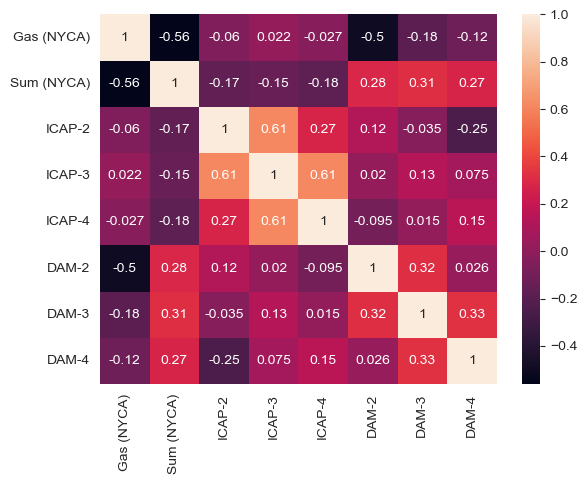

In [272]:
sns.heatmap(nyca_df.corr(), annot = True)

In [280]:
x = nyca_df.loc[:, nyca_df.columns != 'Gas (NYCA)']
y = nyca_df['Gas (NYCA)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Gas (NYCA)   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     322.4
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           6.65e-66
Time:                        14:26:01   Log-Likelihood:                -1217.8
No. Observations:                 157   AIC:                             2444.
Df Residuals:                     153   BIC:                             2456.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.58e+04    165.599    155.785      0.0

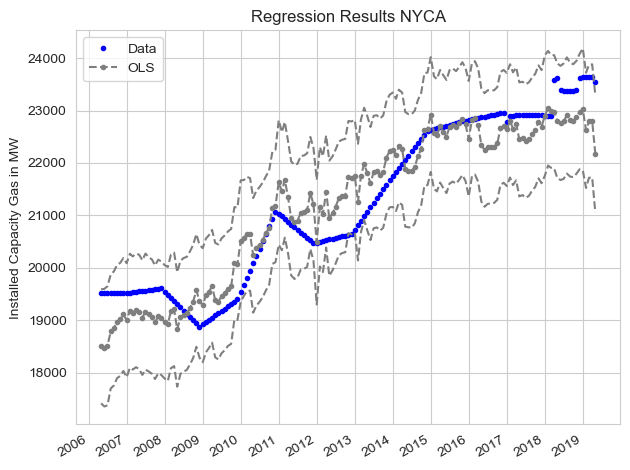

In [216]:
res = model
x = nyca_df.index
y_true = nyca_df['Gas (NYCA)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b.', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(22000, 24500)
ax.set_title('Regression Results NYCA')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [217]:
nyc_df = nyc_reg[['Gas (NYC)', 
                    #'Coal (NYC)',
                    # 'Oil (NYC)', 
                    #'Renewables (NYC)', 
                    #'Others (NYC)',
                    #'Sum (NYC)',
                    'Sum_woGas (NYC)',
                    #'nyc_icap',
                    #'natural gas', 
                    #'nyc_dam', 
                    #'Cleared Above NYC (%)', 
                    #'UCAP NYC (MW)',
                    #'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    #'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

In [218]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2011-01-01 to 2019-05-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gas (NYC)        101 non-null    float64
 1   Sum_woGas (NYC)  101 non-null    float64
 2   ICAP-2           101 non-null    float64
 3   ICAP-3           101 non-null    float64
 4   ICAP-4           101 non-null    float64
 5   DAM-2            101 non-null    float64
 6   DAM-3            101 non-null    float64
 7   DAM-4            101 non-null    float64
dtypes: float64(8)
memory usage: 7.1 KB


<Axes: >

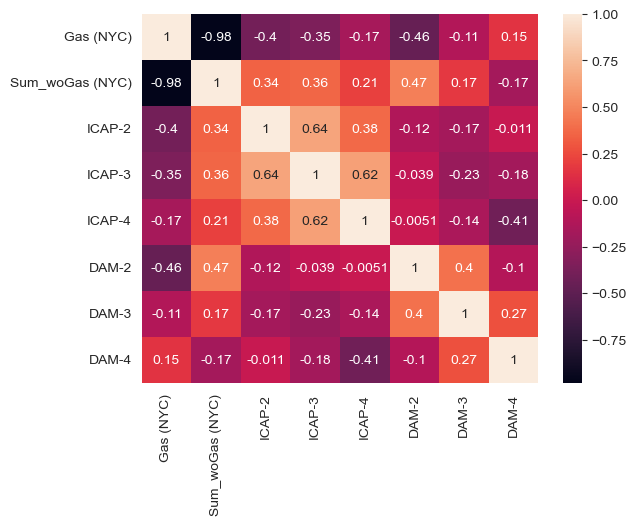

In [219]:
sns.heatmap(nyc_df.corr(), annot = True)

In [220]:
x = nyc_df.loc[:, nyc_df.columns != 'Gas (NYC)']
y = nyc_df['Gas (NYC)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Gas (NYC)   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     721.5
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           4.25e-78
Time:                        14:10:12   Log-Likelihood:                -575.77
No. Observations:                 101   AIC:                             1168.
Df Residuals:                      93   BIC:                             1188.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9688.9002     29.665    3

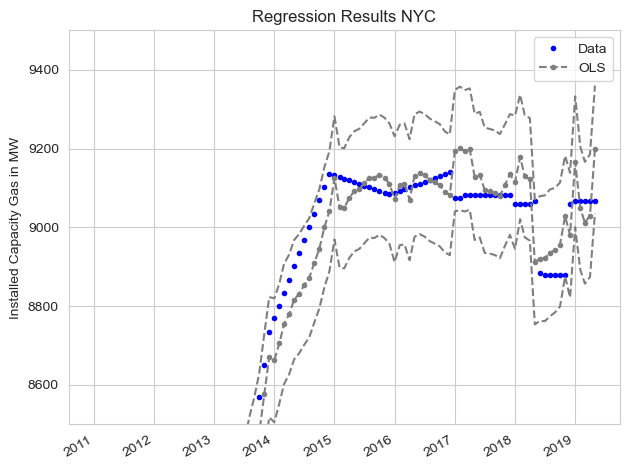

In [221]:
res = model
x = nyc_df.index
y_true = nyc_df['Gas (NYC)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b.', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
ax.set_ylim(8500, 9500)
ax.set_title('Regression Results NYC')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [222]:
gj_df = gj_reg[['Gas (GJ)', 
                    #'Coal (GJ)',
                    # 'Oil (GJ)', 
                    #'Renewables (GJ)', 
                    #'Others (GJ)',
                    #'Sum (GJ)',
                    'Sum_woGas (GJ)',
                    #'gj_icap',
                    #'natural gas', 
                    #'gj_dam', 
                    #'Cleared Above GJ (%)', 
                    #'UCAP GJ (MW)',
                    #'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    #'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

In [223]:
gj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2011-01-01 to 2019-05-01
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gas (GJ)        101 non-null    float64
 1   Sum_woGas (GJ)  101 non-null    float64
 2   ICAP-2          101 non-null    float64
 3   ICAP-3          101 non-null    float64
 4   ICAP-4          101 non-null    float64
 5   DAM-2           101 non-null    float64
 6   DAM-3           101 non-null    float64
 7   DAM-4           101 non-null    float64
dtypes: float64(8)
memory usage: 7.1 KB


<Axes: >

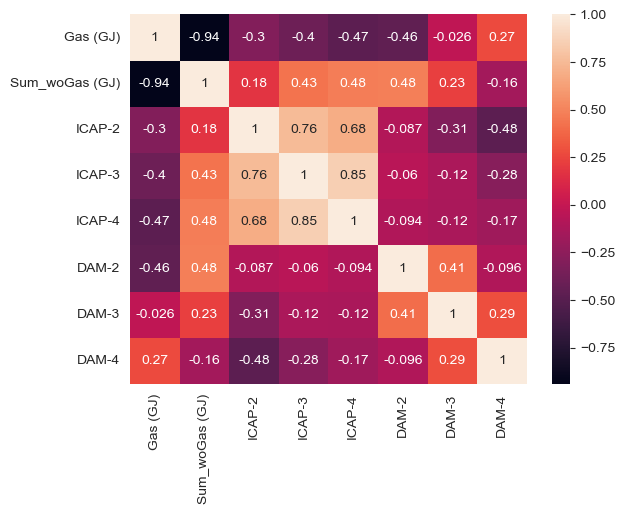

In [224]:
sns.heatmap(gj_df.corr(), annot = True)

In [225]:
x = gj_df.loc[:, gj_df.columns != 'Gas (GJ)']
y = gj_df['Gas (GJ)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (GJ)   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     256.8
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           6.41e-58
Time:                        14:10:15   Log-Likelihood:                -679.71
No. Observations:                 101   AIC:                             1375.
Df Residuals:                      93   BIC:                             1396.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.454e+04     86.631    167.

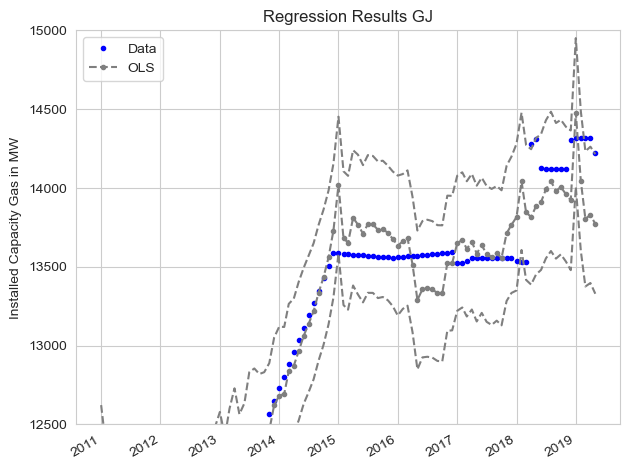

In [226]:
res = model
x = gj_df.index
y_true = gj_df['Gas (GJ)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b.', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
ax.set_ylim(12500, 15000)
ax.set_title('Regression Results GJ')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [227]:
li_df = li_reg[['Gas (LI)', 
                    #'Coal (LI)',
                    # 'Oil (LI)', 
                    #'Renewables (LI)', 
                    #'Others (LI)',
                    #'Sum (LI)',
                    'Sum_woGas (LI)',
                    #'li_icap',
                    #'natural gas', 
                    #'li_dam', 
                    #'Cleared Above LI (%)', 
                    #'UCAP LI (MW)',
                    #'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    #'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

In [228]:
li_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2011-01-01 to 2019-05-01
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gas (LI)        101 non-null    float64
 1   Sum_woGas (LI)  101 non-null    float64
 2   ICAP-2          101 non-null    float64
 3   ICAP-3          101 non-null    float64
 4   ICAP-4          101 non-null    float64
 5   DAM-2           101 non-null    float64
 6   DAM-3           101 non-null    float64
 7   DAM-4           101 non-null    float64
dtypes: float64(8)
memory usage: 7.1 KB


<Axes: >

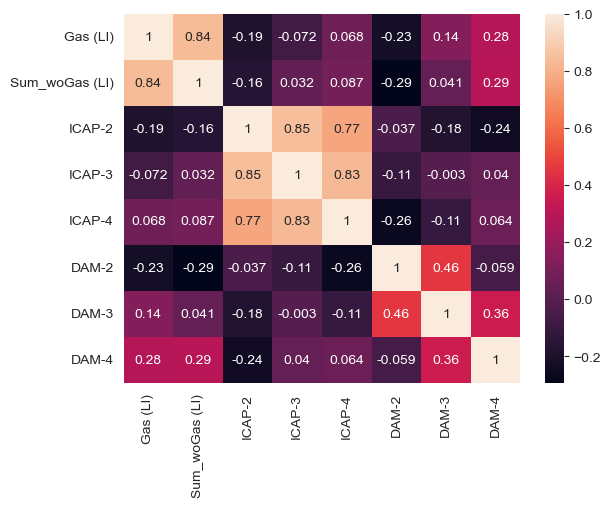

In [229]:
sns.heatmap(li_df.corr(), annot = True)

In [230]:
x = li_df.loc[:, li_df.columns != 'Gas (LI)']
y = li_df['Gas (LI)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (LI)   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     40.50
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           1.41e-25
Time:                        14:10:18   Log-Likelihood:                -496.36
No. Observations:                 101   AIC:                             1009.
Df Residuals:                      93   BIC:                             1030.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2832.9958     84.535     33.

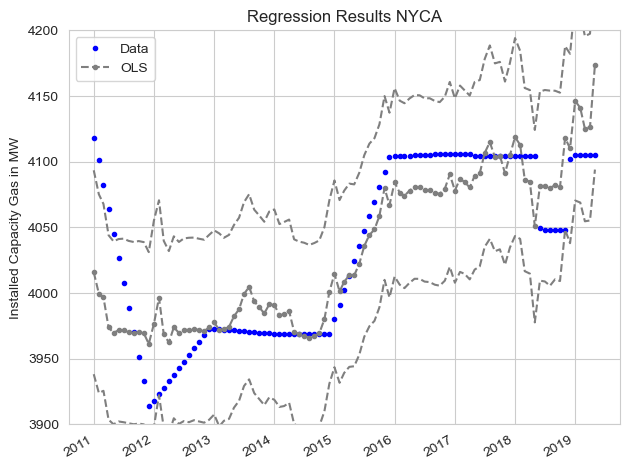

In [231]:
res = model
x = li_df.index
y_true = li_df['Gas (LI)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b.', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
ax.set_ylim(3900, 4200)
ax.set_title('Regression Results NYCA')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()